In [25]:


import scanpy as sc
import squidpy as sq
import pandas as pd 
import scipy
import numpy as np 
from kernel_cross_rho import kernel_cross_rho
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")


# Read in the data

In [13]:

visium_obj = sc.read_visium("../data/V11L12-038_D1/visium",library_id='myLib')
msi_obj = sc.read_visium('../data/V11L12-038_D1/msi_coregistered',library_id='myLib')
visium_obj.var_names_make_unique()
msi_obj.var_names_make_unique()


# Apply normalization and log1p

In [14]:
sc.pp.normalize_total(visium_obj,target_sum=1e4, inplace=True)
sc.pp.log1p(visium_obj)
sc.pp.normalize_total(msi_obj, target_sum=1e4, inplace=True)
sc.pp.log1p(msi_obj)


# Filter on minimal spot count, and Moran's I spatial autocorrelation

We filter to genes and msi peaks to improve statistical power when filtering on Moran's I FDR.
We filter on Moran's I to reduce the list of features to those with spatial patterns. 


In [17]:
sc.pp.filter_genes(visium_obj, min_cells=10)
sc.pp.filter_genes(msi_obj, min_cells=10)
sq.gr.spatial_neighbors(visium_obj)
sq.gr.spatial_neighbors(msi_obj)
sq.gr.spatial_autocorr(visium_obj, mode="moran", n_jobs=4)
sq.gr.spatial_autocorr(msi_obj, mode="moran", n_jobs=4)
moran_df_vis = visium_obj.uns["moranI"]
print(f"Visium Moran’s I: {moran_df_vis['pval_norm_fdr_bh'].isna().sum()} NaN FDRs")
print(f"Visium Moran’s I: {(moran_df_vis['pval_norm_fdr_bh'] < 0.05).sum()} genes pass FDR<0.05")
moran_df_msi = msi_obj.uns["moranI"]
print(f"MSI Moran’s I: {moran_df_msi['pval_norm_fdr_bh'].isna().sum()} NaN FDRs")
print(f"MSI Moran’s I: {(moran_df_msi['pval_norm_fdr_bh'] < 0.05).sum()} msi peaks pass FDR<0.05")

Visium Moran’s I: 0 NaN FDRs
Visium Moran’s I: 7807 genes pass FDR<0.05
MSI Moran’s I: 0 NaN FDRs
MSI Moran’s I: 3035 msi peaks pass FDR<0.05


# Compute Rank-based Distance Weighted Cross-modality Correlation.

In [19]:
top_k = 500
top_genes = moran_df_vis["I"].sort_values(ascending=False).head(top_k).index
top_peaks = msi_obj.uns["moranI"]["I"].sort_values(ascending=False).head(top_k).index

vis_filt_topk = visium_obj[:, top_genes].copy()
msi_filt_topk = msi_obj[:, top_peaks].copy()

R_topk = kernel_cross_rho(vis_filt_topk, msi_filt_topk, sigma=55.0, rank=True)



# Investigate highest correlated mz-peak to genes.

In [20]:
def get_top_hits_df(R, visium_obj, msi_obj, top_n = 30):
    Rdf = pd.DataFrame(R,
                    index=visium_obj.var_names,
                    columns=msi_obj.var_names)

    top_hits = (Rdf.abs()
                    .stack()
                    .sort_values(ascending=False)
                    .head(top_n))       # strongest 30 |ρ|

    print(top_hits)
    return Rdf, top_hits

Rdf_topk, top_hits_topk = get_top_hits_df(R_topk, vis_filt_topk, msi_filt_topk, top_n=125)

Mbp     mz-300.03943     0.689125
        mz-259.014125    0.686166
        mz-259.012915    0.686069
        mz-518.00086     0.684773
        mz-888.62124     0.678908
                           ...   
Mobp    mz-904.615055    0.570392
Gng7    mz-275.01739     0.570267
        mz-124.007135    0.570172
Gpr88   mz-253.049875    0.569654
Snap25  mz-383.016235    0.569585
Length: 125, dtype: float64


# Plot Clustermap

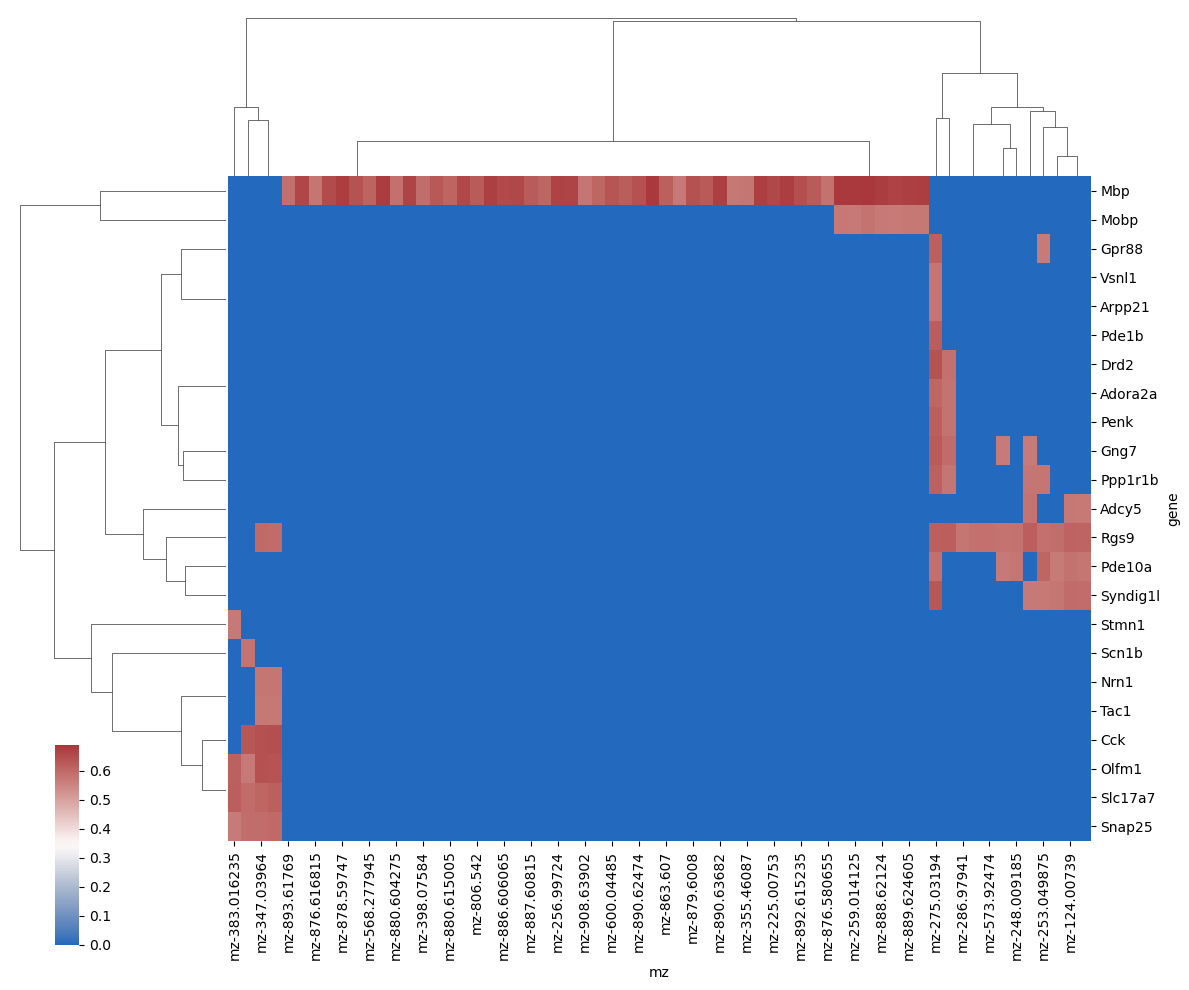

In [21]:
top_df = top_hits_topk.reset_index()
top_df.columns = ['gene', 'mz', 'correlation']

# Create a pivot table (genes as rows, m/z as columns)
submatrix = top_df.pivot(index='gene', columns='mz', values='correlation').fillna(0)
submatrix

import seaborn as sns
import matplotlib.pyplot as plt

# Create the clustermap with the colorbar in the lower-left
g = sns.clustermap(
    submatrix,
    cmap="vlag",
    metric="correlation",
    figsize=(12, 10),
    cbar_pos=(0.05, 0.05, 0.02, 0.2)  # (x, y, width, height)
)

# Save to file
output_path = "../fig/clustermap_genes_mz.png"
g.fig.savefig(output_path, dpi=300, bbox_inches='tight')


# Plot Specific assocations

## Rgs9 : mz-275.03194

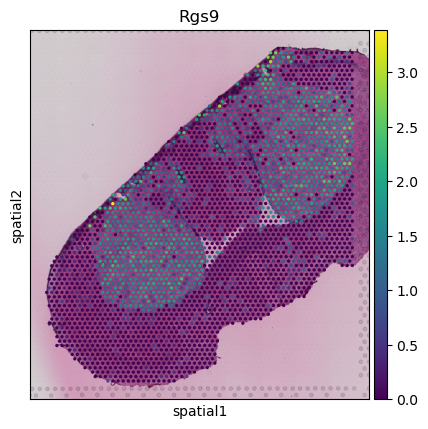

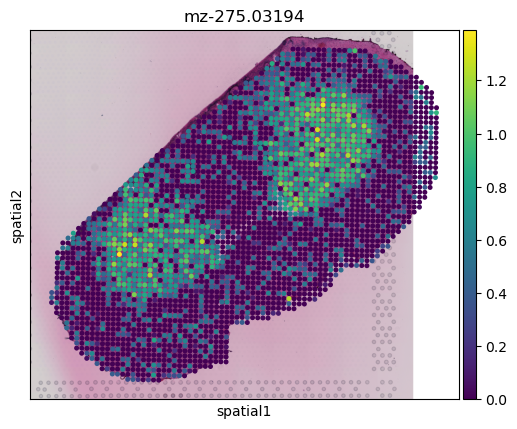

In [27]:
sc.settings.figdir = "../fig"

gene = 'Rgs9'
mz   = 'mz-275.03194'

sc.pl.spatial(
    visium_obj,
    color=gene,
    save=f"{gene}_gene.png"
)        

sc.pl.spatial(
    msi_obj,
    color=mz,
    save=f"{mz}_msi.png"          
)


In [ ]:
## Mbp : mz-259.014125

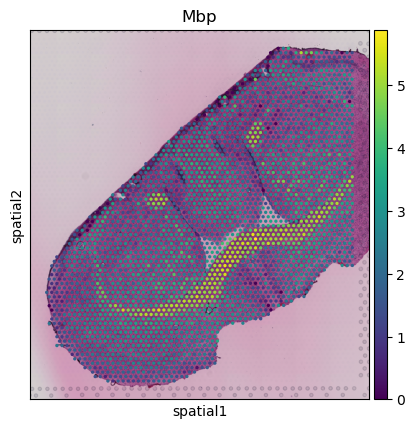

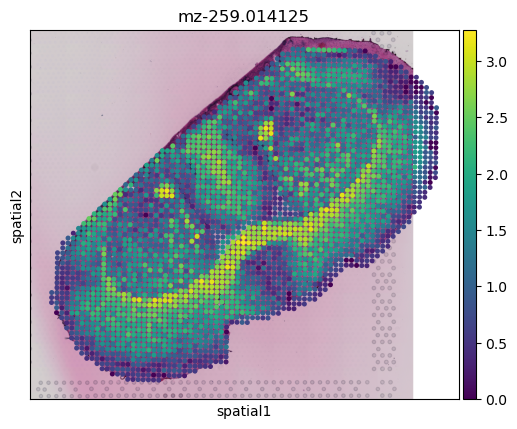

In [28]:
gene = 'Mbp'
mz   = 'mz-259.014125'

sc.pl.spatial(
    visium_obj,
    color=gene,
    save=f"{gene}_gene.png"
)        

sc.pl.spatial(
    msi_obj,
    color=mz,
    save=f"{mz}_msi.png"          
)